In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/sop-covid/voice/model_rnn/breath

/content/drive/MyDrive/sop-covid/voice/model_rnn/breath


In [3]:
!unzip ../../data_rnn/data_breath.zip

Archive:  ../../data_rnn/data_breath.zip
replace data_breath/valid_y.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [56]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import pickle
import os

import sys
sys.path.append('..')

from utils import *

In [5]:
SEED = 1
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [6]:
train_X = np.load(os.path.join('data_breath', 'train_X.npy'))
train_y = np.load(os.path.join('data_breath', 'train_y.npy'))

valid_X = np.load(os.path.join('data_breath', 'valid_X.npy'))
valid_y = np.load(os.path.join('data_breath', 'valid_y.npy'))

test_X = np.load(os.path.join('data_breath', 'test_X.npy'))
test_y = np.load(os.path.join('data_breath', 'test_y.npy'))

In [7]:
sc = Scaler()
sc.fit(train_X, (0, 1))

train_X_n = sc.transform(train_X, 'normalize')
train_X_s = sc.transform(train_X, 'standardize')

valid_X_n = sc.transform(valid_X, 'normalize')
valid_X_s = sc.transform(valid_X, 'standardize')

test_X_n = sc.transform(test_X, 'normalize')
test_X_s = sc.transform(test_X, 'standardize')

In [8]:
# Undersampling the majority class to make the distribution 50:50.
train_X_n_under = train_X[:int(2 * train_y.sum())]
train_y_under = train_y[:int(2 * train_y.sum())]

valid_X_n_under = valid_X[:int(2 * valid_y.sum())]
valid_y_under = valid_y[:int(2 * valid_y.sum())]

test_X_n_under = test_X[:int(2 * test_y.sum())]
test_y_under = test_y[:int(2 * test_y.sum())]

In [42]:
# Hyperparameters
learning_rate = 1e-3
epochs = 100
batch_size = 256

In [43]:
# Callback for early stopping
es_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=5,
    restore_best_weights=True
)

# Callback for reducing learning rate on loss plateauing
plateau_callback = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_delta=0.0001
)

In [44]:
metrics = [
           keras.metrics.BinaryAccuracy(name='acc'),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           keras.metrics.AUC(name='auc'),
           keras.metrics.TruePositives(name='tp'),
           keras.metrics.FalsePositives(name='fp'),
           keras.metrics.TrueNegatives(name='tn'),
           keras.metrics.FalseNegatives(name='fn')
]

In [45]:
model = keras.Sequential([
    keras.layers.LSTM(32, activation='tanh', return_sequences=True, input_shape=train_X.shape[1:]),
    keras.layers.LSTM(32, activation='tanh', return_sequences=False),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [46]:
model.compile(
    optimizer=keras.optimizers.Adam(lr=learning_rate),
    loss='binary_crossentropy',
    metrics=metrics
)

In [47]:
# %%script echo "Comment line with %%script echo to run this cell."

history = model.fit(
    train_X_n_under,
    train_y_under,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(valid_X_n_under, valid_y_under),
    callbacks=[es_callback, plateau_callback],
    shuffle=True
)

Epoch 1/100
2/2 [==============================] - 2s 830ms/step - loss: 0.6952 - acc: 0.5036 - precision: 0.5020 - recall: 0.9343 - auc: 0.5247 - tp: 128.0000 - fp: 127.0000 - tn: 10.0000 - fn: 9.0000 - val_loss: 0.6988 - val_acc: 0.5000 - val_precision: 0.5000 - val_recall: 0.8824 - val_auc: 0.4152 - val_tp: 15.0000 - val_fp: 15.0000 - val_tn: 2.0000 - val_fn: 2.0000
Epoch 2/100
2/2 [==============================] - 1s 259ms/step - loss: 0.6898 - acc: 0.5219 - precision: 0.5124 - recall: 0.9051 - auc: 0.5578 - tp: 124.0000 - fp: 118.0000 - tn: 19.0000 - fn: 13.0000 - val_loss: 0.7005 - val_acc: 0.4706 - val_precision: 0.4839 - val_recall: 0.8824 - val_auc: 0.4602 - val_tp: 15.0000 - val_fp: 16.0000 - val_tn: 1.0000 - val_fn: 2.0000
Epoch 3/100
2/2 [==============================] - 1s 260ms/step - loss: 0.6880 - acc: 0.5219 - precision: 0.5123 - recall: 0.9124 - auc: 0.5862 - tp: 125.0000 - fp: 119.0000 - tn: 18.0000 - fn: 12.0000 - val_loss: 0.6998 - val_acc: 0.4706 - val_precision

In [48]:
# %%script echo "Comment line with %%script echo to run this cell."

model.save('lstm.h5')

In [50]:
# %%script echo "Comment line with %%script echo to run this cell."

with open('lstm_history.pickle', 'wb') as f:
    pickle.dump(history.history, f)

In [51]:
model = keras.models.load_model('lstm.h5')

In [52]:
with open('lstm_history.pickle', 'rb') as f:
    history = pickle.load(f)

In [53]:
model.predict(test_X_n_under)

array([[0.28703016],
       [0.8421237 ],
       [0.8172998 ],
       [0.8426855 ],
       [0.27176014],
       [0.29760852],
       [0.8272436 ],
       [0.7941834 ],
       [0.6395502 ],
       [0.88107735],
       [0.26951727],
       [0.75756514],
       [0.41921157],
       [0.6637735 ],
       [0.7746903 ],
       [0.81099457],
       [0.3905488 ],
       [0.8833747 ],
       [0.27312326],
       [0.29062334],
       [0.29828215],
       [0.26135537],
       [0.32205912],
       [0.25605372],
       [0.839674  ],
       [0.8146493 ],
       [0.8350098 ],
       [0.83952934],
       [0.29537383],
       [0.37081316],
       [0.8443288 ],
       [0.31241837],
       [0.8861281 ],
       [0.29838157],
       [0.5962859 ],
       [0.8833613 ]], dtype=float32)

In [54]:
model.evaluate(test_X_n_under, test_y_under)

2/2 [==============================] - 0s 77ms/step - loss: 0.7634 - acc: 0.6111 - precision: 0.6000 - recall: 0.6667 - auc: 0.5694 - tp: 12.0000 - fp: 8.0000 - tn: 10.0000 - fn: 6.0000


[0.763353168964386,
 0.6111111044883728,
 0.6000000238418579,
 0.6666666865348816,
 0.5694444179534912,
 12.0,
 8.0,
 10.0,
 6.0]

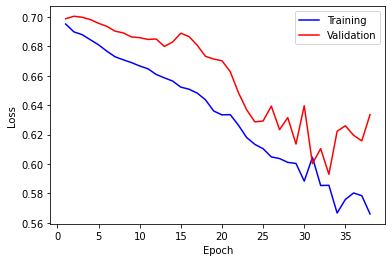

In [57]:
plt.plot(
    np.arange(1, len(history['loss']) + 1),
    history['loss'],
    color='b',
    label='Training'
)
plt.plot(
    np.arange(1, len(history['val_loss']) + 1),
    history['val_loss'],
    color='r',
    label='Validation'
)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(0, len(history['loss']) + 1, 5))
plt.legend()

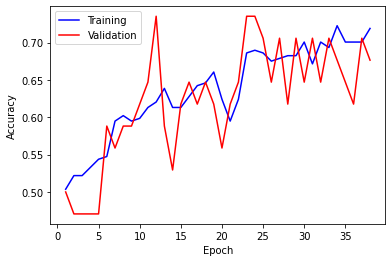

In [58]:
plt.plot(
    np.arange(1, len(history['acc']) + 1),
    history['acc'],
    color='b',
    label='Training'
)
plt.plot(
    np.arange(1, len(history['val_acc']) + 1),
    history['val_acc'],
    color='r',
    label='Validation'
)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0, len(history['loss']) + 1, 5))
plt.legend()